# CW1 - Multimodal IMDB Analysis with Keras

## Introduction

In this assignment you will be provided a dataset containing a selection of films together with their posters in JPEG image format and their overviews in text format from the Internet Movie Database.

![Example](https://i.ibb.co/J3trT62/Screenshot-2024-09-22-214753.png)

You will be analysing this dataset by implementing and training two models: a **CNN** and an **LSTM**.

The CNN must classify film posters by the genre. Independently, the LSTM must classify film overviews by the genre. Finally, you will evaluate and critically comment your results in a short report. (Which of the two models was better at classifying films?)

## Structure of the assignment

This assignment is broken up into sections and you need to complete each section successively. The sections are the following:

1. Data Processing

  1.a. Image processing of the posters

  1.b. Natural language processing of the overviews

2. Definition of the models

  2.a. CNN for the posters

  2.b. LSTM for the overviews

3. Training of the models
4. Evaluation of the models

In addition to this coding exercise, you must write a **2-3 pages** report analysing and critically evaluating your model's results. Marks for the report will be awarded for depth of analysis and critical thinking skills. You should consider how well your model performs and WHY it does that—give specific examples and comment on their importance.

In [73]:
# Enter your module imports here, some modules are already provided

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import pandas as pd
from sklearn import model_selection
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.metrics import Precision, Recall
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Flatten, Dense

In [74]:
# CodeGrade Tag Init1
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Data Processing

Warning: running the following cell can take some time.


In [75]:
# CodeGrade Tag Init2
# Do not edit, remove, or copy this cell

# This code will copy the images from your google drive into the colab file
# storage. Make sure the dataset is unzipped in your drive folder.
! mkdir /tmp/Multimodal_IMDB_dataset
! rsync -ah --info=progress2 /content/drive/MyDrive/Multimodal_IMDB_dataset/Images /tmp/Multimodal_IMDB_dataset/


mkdir: cannot create directory ‘/tmp/Multimodal_IMDB_dataset’: File exists
              0   0%    0.00kB/s    0:00:00 (xfr#0, to-chk=0/7897)   


In [76]:
# CodeGrade Tag Init3
# Do not edit, remove, or copy this cell

# Load the csv with the sample IDs and genres
csv_loc = "/content/drive/MyDrive/Multimodal_IMDB_dataset/IMDB_overview_genres.csv"
dataset = pd.read_csv(csv_loc)

# Split the dataset into training and testing
data_train, data_test = model_selection.train_test_split(dataset, test_size=0.2)

# Convert the labels to arrays
labels_train = np.array(data_train.drop(['Id', 'Genre', 'Overview'],axis=1)).astype('float32')
labels_test = np.array(data_test.drop(['Id', 'Genre', 'Overview'],axis=1)).astype('float32')

# List of the genre names
genres = np.array(data_train.drop(['Id', 'Genre', 'Overview'],axis=1).columns)

# List of overviews
overviews_train = np.array(data_train['Overview'])
overviews_test = np.array(data_test['Overview'])

# Build the file locations for the images
img_loc = "/tmp/Multimodal_IMDB_dataset/Images"

img_locs_train = np.array([[img_loc + '/' + id + '.jpg' for id in data_train['Id']]])
img_locs_test = [[img_loc + '/' + id + '.jpg' for id in data_test['Id']]]

# This function is provided to read in the image files from the folder
def parse_image(filename, label):
  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  return image, label


### 1.a. Image processing of the posters

In [77]:
# CodeGrade Tag Init4
# Do not edit, remove, or copy this cell

# Create the initial datasets of film posters
list_posters_train_ds = tf.data.Dataset.from_tensor_slices((img_locs_train[0], labels_train))
list_posters_valid_ds = tf.data.Dataset.from_tensor_slices((img_locs_test[0], labels_test))

* Create a function called ```img_process``` that converts the images to float32 datatype and resizes them to 64x64 pixels

In [78]:
# CodeGrade Tag Ex1a-i
### Create a function called img_process that converts the images to
### float32 datatype and resizes them to 64x64 pixels

def img_process(image, label):

  image = tf.image.convert_image_dtype(image, dtype = tf.float32)

  # resizing image
  image = tf.image.resize(image, [64,64])

  return image, label

* **Using the ``tf.data`` API, load in the training and validation data for the posters. Be mindful of efficient data processing good practice to minimise the time it takes to load the data.**

In [79]:
# CodeGrade Tag Ex1a-ii
### Use the parse_image and img_process functions to construct the training and
### validation datasets. You should utilise good practice in optimising the
### dataset loading. Use a batch size of 64.

# Batch size
batch_size = 64

# Parse and process the training dataset with batch vectorization
posters_train_ds = (
    list_posters_train_ds
    .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)  # Parse images
    .batch(batch_size)  # Batch the dataset
    .map(img_process, num_parallel_calls=tf.data.AUTOTUNE)  # Process the batch
    .cache()  # Cache for performance
    .shuffle(buffer_size=1000)  # Shuffle for randomness
    .prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch to improve latency
)

# Parse and process the validation dataset with batch vectorization
posters_valid_ds = (
    list_posters_valid_ds
    .map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)  # Parse images
    .batch(batch_size)  # Batch the dataset
    .map(img_process, num_parallel_calls=tf.data.AUTOTUNE)  # Process the batch
    .cache()  # Cache for performance
    .prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch to improve latency
)


### 1.b. Natural Language processing of the overviews

In [80]:
# CodeGrade Tag Init5
# Do not edit, remove, or copy this cell

# Create the initial datasets of the film overviews
list_overviews_train_ds = tf.data.Dataset.from_tensor_slices((overviews_train, labels_train))
list_overviews_valid_ds = tf.data.Dataset.from_tensor_slices((overviews_test, labels_test))

* **Using the ``tf.data`` API, load in the training and validation data for the overviews.**

In [81]:
# CodeGrade Tag Ex1b-i
### Construct the training and validation datasets. Use a batch size of 64.

# Batch size
batch_size = 64

# Placeholder for preprocessing function (e.g., tokenization)
def process_text(text, label):
    # Convert text to lower case, strip whitespace, or apply tokenization
    text = tf.strings.lower(text)
    text = tf.strings.strip(text)
    return text, label

# Training dataset
overviews_train_ds = (
    list_overviews_train_ds
    .map(process_text, num_parallel_calls=tf.data.AUTOTUNE)  # Process text
    .batch(batch_size)  # Batch the dataset
    .cache()  # Cache for performance
    .shuffle(buffer_size=1000)  # Shuffle for randomness
    .prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch to improve latency
)

# Validation dataset
overviews_valid_ds = (
    list_overviews_valid_ds
    .map(process_text, num_parallel_calls=tf.data.AUTOTUNE)  # Process text
    .batch(batch_size)  # Batch the dataset
    .cache()  # Cache for performance
    .prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch to improve latency
)


* Build the vocabulary of the model by calling the ``encoder.adapt()`` method on the film overviews train data.

In [82]:
# CodeGrade Tag Ex1b-ii
### Build the vocabulary of the model by calling the encoder.adapt() method on
### the film overviews train data.

# Constants
VOCAB_SIZE = 10000  # Set the desired vocabulary size
SEQUENCE_LENGTH = 100  # Define a fixed sequence length
BATCH_SIZE = 64  # Batch size for loading data

# Define the TextVectorization layer with output_sequence_length
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,  # Limit the size of the vocabulary
    output_mode='int',  # Convert tokens to integers
    output_sequence_length=SEQUENCE_LENGTH  # Pad/truncate to a fixed length
)

# Process the training dataset: map the overview (text) and label separately
overviews_train_ds_processed = (
    list_overviews_train_ds
    .map(lambda overview, label: overview)  # Extract only the overview text
    .batch(BATCH_SIZE)  # Apply batching first
)

# Adapt the encoder to the training dataset
encoder.adapt(overviews_train_ds_processed)


* Print the first 200 words of the vocabulary you obtained.

In [83]:
# CodeGrade Tag Ex1b-iii
### Print the first 200 words of the vocabulary you obtained.

vocabulary = encoder.get_vocabulary()

# Print the first 200 words (tokens) of the vocabulary
print(vocabulary[:200])

['', '[UNK]', 'a', 'the', 'to', 'of', 'and', 'in', 'his', 'is', 'an', 'with', 'her', 'for', 'on', 'he', 'their', 'who', 'by', 'when', 'from', 'as', 'that', 'after', 'young', 'life', 'they', 'man', 'at', 'him', 'two', 'new', 'are', 'but', 'into', 'has', 'she', 'up', 'woman', 'love', 'family', 'one', 'out', 'find', 'must', 'friends', 'be', 'world', 'story', 'finds', 'it', 'school', 'them', 'where', 'about', 'while', 'group', 'years', 'girl', 'have', 'father', 'town', 'lives', 'wife', 'three', 'home', 'help', 'city', 'all', 'get', 'war', 'becomes', 'during', 'back', 'son', 'boy', 'only', 'which', 'between', 'himself', 'time', 'york', 'gets', 'high', 'against', 'american', 'tries', 'police', 'other', 'murder', 'mother', 'former', 'falls', 'takes', 'own', 'daughter', 'before', 'friend', 'team', 'small', 'its', 'down', 'order', 'being', 'will', 'become', 'can', 'death', 'old', 'was', 'save', 'college', 'agent', 'way', 'this', 'together', 'take', 'through', 'people', 'not', 'over', 'goes', 's

# 2. Definition of the models

### 2.a. CNN

**Using the Keras Functional API, create a convolutional neural network with the architecture shown in the model summary below.**

**A few important points to consider:**

* Call the convolutional layers and the first dense layer should have ReLU activation functions. The output layer should have a Sigmoid activation function.
* Pay attention to the output shapes and the number of partmeters for each layer, as these give indications as to the correct settings for the number of filters, kernel size, stride length and padding.
* Use the layer names provided in the summary in your model.
* For the dropout layers, use a dropout rate of 0.2 after the convolutional layers and 0.5 after the dense layers.


```
# Model Summary

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 32, 32, 16)        448       
                                                                 
 Drop1 (Dropout)             (None, 32, 32, 16)        0         
                                                                 
 Conv1 (Conv2D)              (None, 32, 32, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 Drop2 (Dropout)             (None, 32, 32, 32)        0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 Conv4 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 Drop3 (Dropout)             (None, 16, 16, 64)        0         
                                                                 
 Pool2 (MaxPooling2D)        (None, 8, 8, 64)          0         
                                                                 
 Conv5 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 Conv6 (Conv2D)              (None, 8, 8, 128)         147584    
                                                                 
 Drop4 (Dropout)             (None, 8, 8, 128)         0         
                                                                 
 Pool3 (MaxPooling2D)        (None, 4, 4, 128)         0         
                                                                 
 Flat (Flatten)              (None, 2048)              0         
                                                                 
 FC1 (Dense)                 (None, 1024)              2098176   
                                                                 
 Drop5 (Dropout)             (None, 1024)              0         
                                                                 
 FC2 (Dense)                 (None, 1024)              1049600   
                                                                 
 Drop6 (Dropout)             (None, 1024)              0         
                                                                 
 Output (Dense)              (None, 25)                25625     
                                                                 
=================================================================
Total params: 3464601 (13.22 MB)
Trainable params: 3464601 (13.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


```



In [84]:
# CodeGrade Tag Ex2a-i
### Define the model using the Keras Functional API. Use the summary above as a
### guide for the model parameters. You will need to define the filters/units of
### the layers correctly, as well as the kernel size, stride length and padding
### of the convolutional layers.

def build_cnn_model():
    # Input layer
    inputs = Input(shape=(64, 64, 3), name="Input")

    # Conv0 and Drop1
    x = Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu", name="Conv0")(inputs)
    x = Dropout(rate=0.2, name="Drop1")(x)

    # Conv1, Conv2, Drop2, and Pool1
    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", name="Conv1")(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", name="Conv2")(x)
    x = Dropout(rate=0.2, name="Drop2")(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="Pool1")(x)

    # Conv3, Conv4, Drop3, and Pool2
    x = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu", name="Conv3")(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu", name="Conv4")(x)
    x = Dropout(rate=0.2, name="Drop3")(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="Pool2")(x)

    # Conv5, Conv6, Drop4, and Pool3
    x = Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu", name="Conv5")(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu", name="Conv6")(x)
    x = Dropout(rate=0.2, name="Drop4")(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name="Pool3")(x)

    # Flatten Layer
    x = Flatten(name="Flat")(x)

    # Fully Connected Layers with Dropout
    x = Dense(units=1024, activation="relu", name="FC1")(x)
    x = Dropout(rate=0.5, name="Drop5")(x)
    x = Dense(units=1024, activation="relu", name="FC2")(x)
    x = Dropout(rate=0.5, name="Drop6")(x)

    # Output Layer
    outputs = Dense(units=25, activation="sigmoid", name="Output")(x)

    # Create Model
    model = Model(inputs=inputs, outputs=outputs, name="model")

    return model

# Build and summarize the model
cnn_model = build_cnn_model()


* Print the model summary and confirm it has the same architecture as the one provided.

In [85]:
# CodeGrade Tag Ex2a-ii
### Print the model summary and confirm it has the same architecture as the one
### provided.

cnn_model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv0 (Conv2D)                       │ (None, 32, 32, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop1 (Dropout)                      │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop2 (Dropout)                      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool1 (MaxPooling2D)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv4 (Conv2D)                       │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop3 (Dropout)                      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool2 (MaxPooling2D)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv5 (Conv2D)                       │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv6 (Conv2D)                       │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop4 (Dropout)                      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool3 (MaxPooling2D)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flat (Flatten)                       │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC1 (Dense)                          │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop5 (Dropout)                      │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC2 (Dense)                          │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop6 (Dropout)                      │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 25)                  │          25,625 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 3,464,601 (13.22 MB)

 Trainable params: 3,464,601 (13.22 MB)

 Non-trainable params: 0 (0.00 B)

* **Compile the model using the Adam Optimizer with a learning rate of ```1e-4``` and ```binary crossentropy``` loss function. For the metrics, use the ``Precision`` and ``Recall`` functions.**

In [86]:
# CodeGrade Tag Ex2a-iii
### Compile the model using the Adam Optimizer with a learning rate of 1e-4 and
### binary crossentropy loss function. For the metrics, use the Precision and
### Recall functions.

cnn_model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Adam optimizer with learning rate 1e-4
    loss="binary_crossentropy",         # Binary crossentropy loss
    metrics=[Precision(name="precision"), Recall(name="recall")]  # Precision and Recall as metrics
)

### 2.b. LSTM model

* Set up the embedding layer by using ```tf.keras.layers.Embedding```. The ```input_dim``` is the length of the vocab, and the ```output_dim``` must be **265**. You should also set ```mask_zero=True```.

In [87]:
# CodeGrade Tag Ex2b-i
### Set up the embedding layer. The input_dim is the length of the vocab, and
### the output_dim must be 256. You should also set mask_zero=True.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

vocab_size = len(encoder.get_vocabulary())
# Create a Sequential model and add the embedding layer
embedder = Sequential([
    Embedding(
        input_dim=vocab_size,  # Length of the vocabulary
        output_dim=256,        # Output dimensions
        mask_zero=True,        # Mask padding tokens (index 0)
        name="Embedding"
    )
])


* Use ```tf.keras.Sequential``` to build a keras sequential model, with the following layers:



  1.   encoder
  2.   embedder
  3.   biLSTM layer with 256 units, dropout 0.5, recurrent dropout 0.2 (make sure to use the right ```return_sequences``` parametre to be able to stack this layer with the following BiLSTM)
  4.   biLSTM layer with 128 units, dropout 0.5, recurrent dropout 0.2
  5.   dense layer with 128 units and relu activation function
  6.   dropout with rate 0.8
  7.   dense output layer with 25 units and sigmoid activation function



In [88]:
# CodeGrade Tag Ex2b-ii
### Build a keras sequential model, with the layers provided above.

lstm_model = keras.Sequential([
    encoder,
    embedder,
    keras.layers.Bidirectional(keras.layers.LSTM(256, dropout=0.5, recurrent_dropout=0.2, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(128, dropout=0.5, recurrent_dropout=0.2)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.8),
    keras.layers.Dense(25, activation='sigmoid')
])

lstm_model.build((None,))

* Print the model summary and confirm is has the same architecture as the outline provided above.

In [89]:
# CodeGrade Tag Ex2b-iii
### Print the model summary and confirm is has the same architecture as the
### outline provided above.

lstm_model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_1                 │ (None, 100)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_12 (Sequential)           │ (None, 100, 256)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 100, 512)            │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 256)                 │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 25)                  │           3,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,303,129 (16.42 MB)

 Trainable params: 4,303,129 (16.42 MB)

 Non-trainable params: 0 (0.00 B)

* Compile the model with binary crossentropy loss and the adam optimizer. For the metrics, use the Precision and Recall functions.

In [90]:
# CodeGrade Tag Ex2b-iv
### Compile the model with binary crossentropy loss, the adam optimizer, with
### the precision and recall metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

# Compile the model
lstm_model.compile(
    loss="binary_crossentropy",  # Loss function for multi-label classification
    optimizer=Adam(learning_rate=1e-4),  # Adam optimizer with learning rate of 1e-4
    metrics=[Precision(), Recall()]  # Precision and Recall as metrics
)


# 3. Training of the models

* **For each model, create a Checkpoint Callback that saves the weights of the best performing epoch, based on the validation loss.**

In [91]:
# CodeGrade Tag Ex3a-i
### Create two ModelCheckpoint callbacks to store the bext weights from each
### model, both based on the validation loss.

checkpoint_cnn_filepath = '/content/checkpoint_cnn.weights.h5'
checkpoint_lstm_filepath = '/content/checkpoint_lstm.weights.h5'

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cnn_callback = ModelCheckpoint(
    checkpoint_cnn_filepath,       # Save the weights to this file
    monitor='val_loss',            # Monitor validation loss
    save_best_only=True,           # Save only the best model (lowest validation loss)
    mode='min',                    # Minimize the validation loss
    save_weights_only=True,        # Save only the weights, not the full model
    verbose=1                      # Show a message when the model is saved
)

# Create the ModelCheckpoint callback for the LSTM model
checkpoint_lstm_callback = ModelCheckpoint(
    checkpoint_lstm_filepath,      # Save the weights to this file
    monitor='val_loss',            # Monitor validation loss
    save_best_only=True,           # Save only the best model (lowest validation loss)
    mode='min',                    # Minimize the validation loss
    save_weights_only=True,        # Save only the weights, not the full model
    verbose=1                      # Show a message when the model is saved
)

* **Create a Learning Rate Scheduler Callback that utilises the provided function to decrease the learning rate during training.**

In [92]:
# CodeGrade Tag Ex3a-ii
### Using the function provided, create a LearningRateScheduler callback, call
### it "lr_callback"

from tensorflow.keras.callbacks import LearningRateScheduler

# Provided function to adjust the learning rate during training
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)  # Keep the learning rate constant for the first 10 epochs
    else:
        return float(lr * tf.math.exp(-0.01))  # Decay the learning rate after epoch 10

# Create the LearningRateScheduler callback using the scheduler function
lr_callback = LearningRateScheduler(scheduler,verbose=1)

### 3.a. CNN training

* **Train the CNN model for 40 epochs, using the callbacks you made previously. Store the losses and metrics to use later.**

In [93]:
# CodeGrade Tag Ex3a-iii
### Train the model for 40 epochs, using the callbacks you have created. Store
### the losses and metrics in a history object.

cnn_history = cnn_model.fit(
    posters_train_ds,            # Training dataset
    epochs=40,                   # Train for 40 epochs
    validation_data=posters_valid_ds,  # Validation dataset
    callbacks=[checkpoint_cnn_callback, lr_callback],  # Callbacks: checkpoint and learning rate scheduler
    verbose=1                     # Print training progress
)


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/40
77/80 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.4121 - precision: 0.2318 - recall: 0.2208
Epoch 1: val_loss improved from inf to 0.34238, saving model to /content/checkpoint_cnn.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 131ms/step - loss: 0.4074 - precision: 0.2368 - recall: 0.2208 - val_loss: 0.3424 - val_precision: 0.5383 - val_recall: 0.2278 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2568 - precision: 0.4946 - recall: 0.2169
Epoch 2: val_loss improved from 0.34238 to 0.32178, saving model to /content/checkpoint_cnn.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2567 - precision: 0.4948 - recall: 0.2170 - val_loss: 0.3218 - val_precision: 0.5645 - val_recall: 0.3226 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999

* **Train the model for 20 epochs** (this may take several minutes)**, using the callbacks you made previously. Store the losses and metrics to use later.**

In [94]:
# CodeGrade Tag Ex3b-i
# Train the model for 20 epochs.

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall


lstm_history = lstm_model.fit(
    overviews_train_ds,             # Training dataset for overviews
    epochs=20,                      # Train for 20 epochs
    validation_data=overviews_valid_ds,  # Validation dataset for overviews
    callbacks=[checkpoint_lstm_callback, lr_callback],  # Callbacks: checkpoint and learning rate scheduler
    verbose=1                        # Print training progress
)


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.6549 - precision_3: 0.1188 - recall_3: 0.4090
Epoch 1: val_loss improved from inf to 0.33797, saving model to /content/checkpoint_lstm.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - loss: 0.6541 - precision_3: 0.1190 - recall_3: 0.4084 - val_loss: 0.3380 - val_precision_3: 0.5383 - val_recall_3: 0.2251 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.4509 - precision_3: 0.1843 - recall_3: 0.3022
Epoch 2: val_loss improved from 0.33797 to 0.28538, saving model to /content/checkpoint_lstm.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - loss: 0.4507 - precision_3: 0.1844 - recall_3: 0.3021 - val_loss: 0.2854 - val_precision_3: 0.5383 - val_recall_3: 0.2251 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting lea

# 4. Evaluation of the models

### 4.a. CNN Evaluation

* **Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the model performance.**

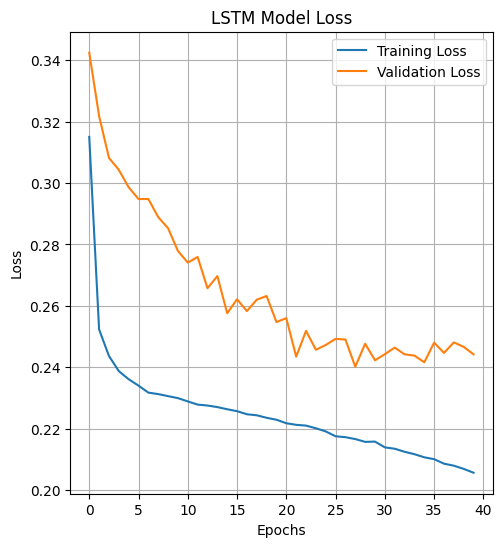

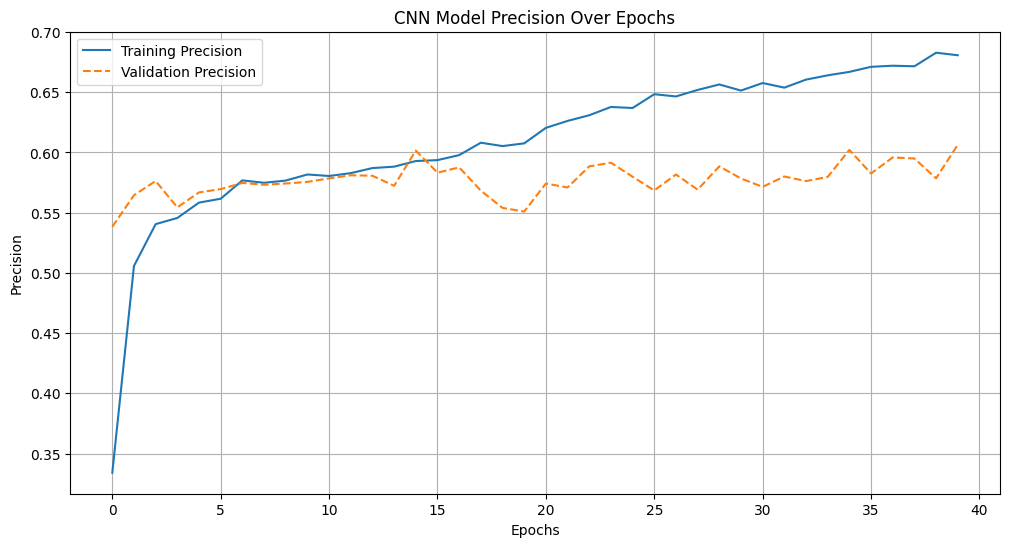

In [ ]:
# CodeGrade Tag Ex4a-i

# Plot for LSTM model loss

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('cnn Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(1)
plt.show()

# Plot for LSTM model accuracy (assuming accuracy was monitored)
# Plotting the Accuracy
# Plot Training and Validation Precision
plt.figure(figsize=(12, 6))

plt.plot(cnn_history.history['precision'], label='Training Precision')
plt.plot(cnn_history.history['val_precision'], label='Validation Precision', linestyle='--')
plt.title('CNN Model Precision Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()


* **Load the best weights from your model checkpoint, and create plots demonstrating the classification performance for all three classes. Include these plots in your report, and critically evaluate on the performance of the model across the classes.**

### 4.b. LSTM Evaluation

* **Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the model performance.**

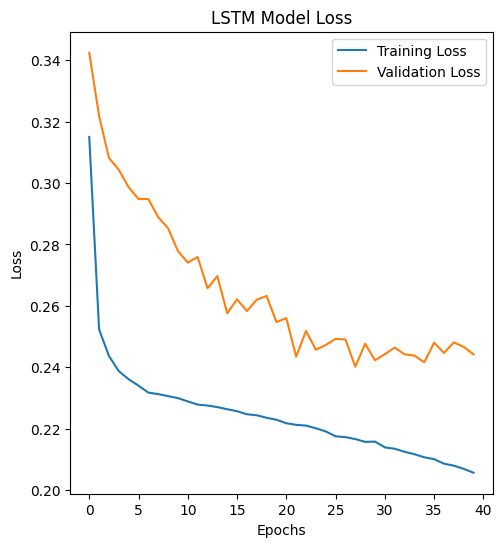

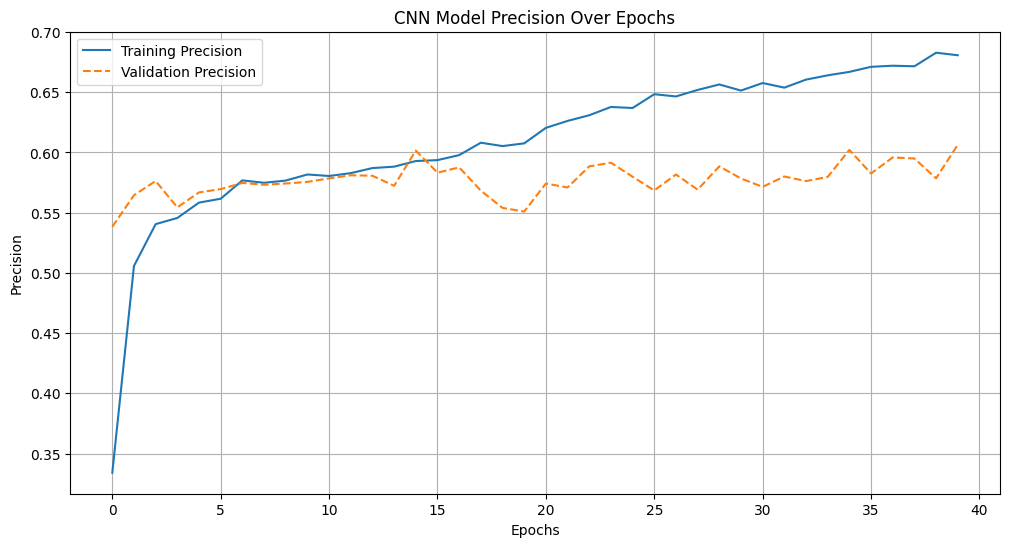

In [ ]:
# CodeGrade Tag Ex4b-i

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for LSTM model accuracy (assuming accuracy was monitored)
# Plotting the Accuracy
# Plot Training and Validation Precision
plt.figure(figsize=(12, 6))

plt.plot(lstm_history.history['precision'], label='Training Precision')
plt.plot(lstm_history.history['val_precision'], label='Validation Precision', linestyle='--')
plt.title('lstm Model Precision Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

### 4.c. Produce examples for the report

* First, load the best weights from your checkpoints of both your models.

* Choose a few films from the dataset, plot their posters and print their overviews. Use these example films to demonstrate the classification performance of the CNN model on their posters and of the LSTM model on their overview.

* Be sure to demonstrate the results of the multi-label classification. Compare, for each example film, the top three most probable genres predicted by the CNN and the top three most probable genres predicted by the LSTM with the ground truth genres.

* Include these examples in your report, and critically evaluate on the performance of the model across the classes.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


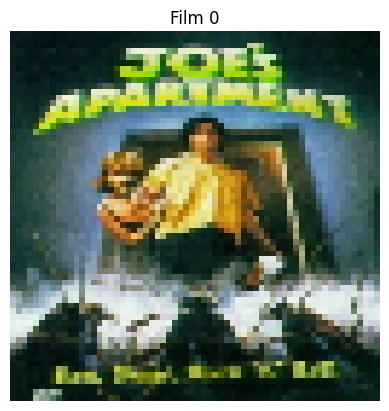

Overview: Follows hard-to-please Aurora looking for love, and her daughter's family problems....

Ground Truth Genres: ['Comedy', 'Drama']
CNN's Top 3 Predicted Genres: ['Family', 'Adventure', 'Crime']
LSTM's Top 3 Predicted Genres: ['Adventure', 'Family', 'Animation']
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


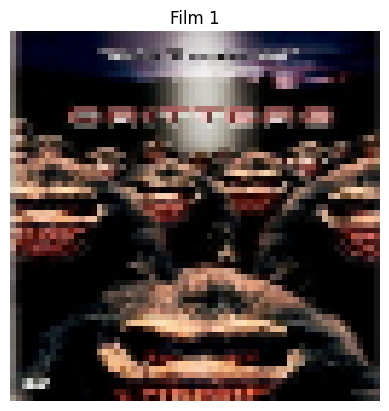

Overview: A Pittsburgh woman with two jobs as a welder and an exotic dancer wants to get into ballet school....

Ground Truth Genres: ['Drama', 'Music', 'Romance']
CNN's Top 3 Predicted Genres: ['Family', 'Adventure', 'Documentary']
LSTM's Top 3 Predicted Genres: ['Family', 'Crime', 'Documentary']
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


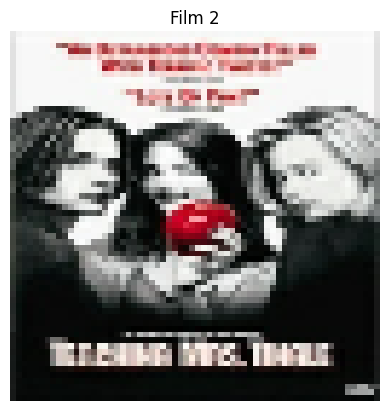

Overview: A snobbish investor and a wily street con artist find their positions reversed as part of a bet by two callous millionaires....

Ground Truth Genres: ['Comedy']
CNN's Top 3 Predicted Genres: ['Family', 'Crime', 'Sci-Fi']
LSTM's Top 3 Predicted Genres: ['Family', 'Crime', 'Adventure']
--------------------------------------------------


In [97]:
# CodeGrade Tag Ex4c
import matplotlib.pyplot as plt
import numpy as np

# Load the best weights for both models
cnn_model.load_weights(checkpoint_cnn_filepath)
lstm_model.load_weights(checkpoint_lstm_filepath)

# Choose a few films (replace with actual indices from your dataset)
example_indices = [0, 1, 2]  # Example indices, replace with your desired film indices

# Function to get top 3 genres
def get_top_3_genres(predictions, genre_names):
    top_3_indices = np.argsort(predictions)[-3:][::-1]  # Get indices of top 3
    top_3_genres = [genre_names[i] for i in top_3_indices]
    return top_3_genres

# Assuming you have 'genre_names' available
genre_names = list(dataset.columns[3:])  # Assuming genres start from column index 3

for i in example_indices:
    # Assuming 'posters_train_ds' and 'overviews_train_ds' are tf.data.Datasets
    # Accessing elements from a tf.data.Dataset requires iteration:

    # Get the poster and overview for the current index
    for j, (image_batch, label_batch) in enumerate(posters_train_ds):
      if j == i:
        poster = image_batch[0] #Assuming one poster per batch for simplicity
        break

    for j, (overview_batch, label_batch) in enumerate(overviews_train_ds):
      if j == i:
        overview = overview_batch[0] # Assuming one overview per batch
        break

    # CNN prediction
    cnn_predictions = cnn_model.predict(np.expand_dims(poster, axis=0))
    top_3_cnn = get_top_3_genres(cnn_predictions[0], genre_names)


    # LSTM prediction
    lstm_predictions = lstm_model.predict(np.expand_dims(overview, axis=0))
    top_3_lstm = get_top_3_genres(lstm_predictions[0], genre_names)


    # Ground truth genres (replace with actual ground truth retrieval method)
    ground_truth = list(dataset.iloc[i][3:])
    ground_truth = [genre_names[idx] for idx, val in enumerate(ground_truth) if val == 1]

    # Plot the poster
    plt.imshow(poster)
    plt.title(f"Film {i}")
    plt.axis('off')
    plt.show()

    # Print the overview (handle potential errors gracefully)
    try:
        print("Overview:", dataset['Overview'].iloc[i][:200] + "...")
    except Exception as e:
        print(f"Error printing overview for film {i}: {e}")


    print("\nGround Truth Genres:", ground_truth)
    print("CNN's Top 3 Predicted Genres:", top_3_cnn)
    print("LSTM's Top 3 Predicted Genres:", top_3_lstm)
    print("-" * 50)
